In [1]:
# Data Source: https://www.kaggle.com/datasets/yasserh/amazon-product-reviews-dataset
# Folder: Amazon
# Description:
### The dataset consists of samples from Amazon Ratings for select products.
### The reviews are picked randomly and the corpus has nearly 1.6k reviews of different customers.
### Amazon aims to understand what are the main topics of these reviews to classify them for easier search.\

# Cleaning, Analysis, Visualization, and Modeling of Amazon Product Reviews Dataset

## Objective
- Understand the Dataset & perform the necessary cleanup.
- Add additional algorithms to go in depth on the positivity of each review
- Build a strong Topic Modelling Algorithm to classify the topics a bit more than what is provided in each review's title.
- Create a regression model to predict product ratings based on the length of reviews 

## Libraries and Tools used throughout
- Pandas (data cleaning and manipulation)
- NLTK & spaCy (NLP)
- sklearn (regression)
- langdetect & googletrans (detecting non-english languages and translating to english)
- Gensim (topic modelling)
- pyLDAvis & matplotlib (visualizing topic model)
- warnings (prevent certain warnings from showing up and or displaying personal information on user's device after execution of a cell)


## In the case of errors:
- Not all python libraries may be on your machine and or within your directory. Ensure to install them.
- You ran a cell with a problematic edit that you made to it(This notebook is designed to run seamlessly with no edits)
- Not running a python kernel or you're using an old version of python kernel
- Don't have libraries or necessary downloads that are necessary for operation of parts or the entirety certain libraries.
    - ex. vader_lexicon is required to be downloaded with Sentiment Analysis(later on in the notebook)
    

In [41]:
import pandas as pd
from pandas.errors import SettingWithCopyWarning
from sklearn.linear_model import LinearRegression  # minimum model to be used later.
import nltk # for NLP
import warnings
warnings.filterwarnings("ignore") # ignore all overall
# warnings.filterwarnings("ignore", category=SettingWithCopyWarning) # ignore a warning later on for copying over on a dataframe.


In [3]:
# load in the file and create dataframe
df = pd.read_csv('product_reviews.csv')
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


## From this we can see that this Dataset contains a lot of columns. For the purpose of our analyses, we only need a few

## For reference, here is a description of each column 

- **id:** Unique identifier for each product.
- **asins:** ASIN (Amazon Standard Identification Number) associated with the product.
- **brand:** Brand of the product.
- **categories:** Categories to which the product belongs.
- **colors:** Colors available for the product.
- **dateAdded:** Date when the product was added.
- **dateUpdated:** Date when the product information was last updated.
- **dimension:** Dimensions of the product.
- **ean:** EAN (European Article Number) associated with the product.
- **keys:** Unique keys associated with the product.
- **manufacturer:** Manufacturer of the product.
- **manufacturerNumber:** Manufacturer number for the product.
- **name:** Name of the product.
- **prices:** Prices associated with the product, including currency and date information.
- **reviews.date:** Date when the review was posted.
- **reviews.doRecommend:** Indicates whether the reviewer recommends the product.
- **reviews.numHelpful:** Number of users who found the review helpful.
- **reviews.rating:** Rating given by the reviewer.
- **reviews.sourceURLs:** URLs to the source of the reviews.
- **reviews.text:** Text content of the review.
- **reviews.title:** Title of the review.
- **reviews.userCity:** City of the reviewer.
- **reviews.userProvince:** Province of the reviewer.
- **reviews.username:** Username of the reviewer.
- **sizes:** Sizes available for the product.
- **upc:** UPC (Universal Product Code) associated with the product.
- **weight:** Weight of the product.


In [4]:
# To get an easier idea of all the columns we are working with, let us see how many exist
df.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'dimension', 'ean', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'prices', 'reviews.date',
       'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sizes',
       'upc', 'weight'],
      dtype='object')

In [5]:
# Lets make a new df including more of what is actually relevant
relevant_columns = ['id', 'asins', 'brand', 'categories', 'colors', 'manufacturer',
        'name', 'prices', 'reviews.date',
       'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating', 'reviews.text', 'reviews.title',
         'sizes', 'weight']
product_reviews = df[relevant_columns]
product_reviews.tail()

,id,asins,brand,categories,colors,manufacturer,name,prices,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title,sizes,weight
1592,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,Amazon,"Amazon Devices & Accessories,Amazon Device Acc...",NaN,NaN,Alexa Voice Remote for Amazon Fire TV and Fire...,"[{""amountMax"":29.99,""amountMin"":29.99,""currenc...",2016-07-06T00:00:00.000Z,NaN,9.0,3.0,This is not the same remote that I got for my ...,I would be disappointed with myself if i produ...,NaN,4 ounces
1593,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,Amazon,"Amazon Devices & Accessories,Amazon Device Acc...",NaN,NaN,Alexa Voice Remote for Amazon Fire TV and Fire...,"[{""amountMax"":29.99,""amountMin"":29.99,""currenc...",2016-06-22T00:00:00.000Z,NaN,41.0,1.0,I have had to change the batteries in this rem...,Battery draining remote!!!!,NaN,4 ounces
1594,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,Amazon,"Amazon Devices & Accessories,Amazon Device Acc...",NaN,NaN,Alexa Voice Remote for Amazon Fire TV and Fire...,"[{""amountMax"":29.99,""amountMin"":29.99,""currenc...",2016-03-31T00:00:00.000Z,NaN,34.0,1.0,"Remote did not activate, nor did it connect to...",replacing an even worse remote. Waste of time,NaN,4 ounces
1595,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,Amazon,"Amazon Devices & Accessories,Amazon Device Acc...",NaN,NaN,Alexa Voice Remote for Amazon Fire TV and Fire...,"[{""amountMax"":29.99,""amountMin"":29.99,""currenc...",2016-04-26T00:00:00Z,NaN,7.0,3.0,It does the job but is super over priced. I fe...,Overpriced,NaN,4 ounces
1596,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,Amazon,"Amazon Devices & Accessories,Amazon Device Acc...",NaN,NaN,Alexa Voice Remote for Amazon Fire TV and Fire...,"[{""amountMax"":29.99,""amountMin"":29.99,""currenc...",2016-07-31T00:00:00Z,NaN,10.0,1.0,I ordered this item to replace the one that no...,I am sending all of this crap back to amazon a...,NaN,4 ounces


# Now that we have a dataset with more of the information we need, we have spotted that a few columns needs restructuring
### Specifically the prices column and the reviews date.

In [6]:
product_reviews['prices'][0]

'[{"amountMax":139.99,"amountMin":139.99,"currency":"USD","dateAdded":"2017-07-18T23:52:58Z","dateSeen":["2017-07-15T18:10:23.807Z","2016-03-16T00:00:00Z"],"isSale":"false","merchant":"Amazon.com","shipping":"FREE Shipping.","sourceURLs":["https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7","http://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built-/dp/B00QJDU3KY"]},{"amountMax":119.99,"amountMin":119.99,"condition":"new","currency":"EUR","dateAdded":"2016-03-08T20:21:53Z","dateSeen":["2016-01-29T00:00:00Z"],"isSale":"false","merchant":"Amazon EU Sarl","shipping":"free","sourceURLs":["http://www.amazon.co.uk/Kindle-Paperwhite-Resolution-Display-Built-/dp/B00QJDU3KY"]},{"amountMax":139.99,"amountMin":139.99,"condition":"new","currency":"CAD","dateAdded":"2016-03-08T20:21:53Z","dateSeen":["2016-01-11T00:00:00Z"],"isSale":"false","merchant":"Amazon","shipp

In [7]:
product_reviews['reviews.date']

0       2015-08-08T00:00:00.000Z
1       2015-09-01T00:00:00.000Z
2       2015-07-20T00:00:00.000Z
3       2017-06-16T00:00:00.000Z
4       2016-08-11T00:00:00.000Z
                  ...           
1592    2016-07-06T00:00:00.000Z
1593    2016-06-22T00:00:00.000Z
1594    2016-03-31T00:00:00.000Z
1595        2016-04-26T00:00:00Z
1596        2016-07-31T00:00:00Z
Name: reviews.date, Length: 1597, dtype: object

In [8]:

# Change format to datetime
product_reviews['reviews.date'] = pd.to_datetime(product_reviews['reviews.date'], format='ISO8601')

# Gets rid of milliseconds
product_reviews['reviews.date'] = product_reviews['reviews.date'].dt.strftime('%Y-%m-%d %H:%M:%S')
product_reviews['reviews.date'].dtype #still datetime but is stored as object

dtype('O')

In [9]:
product_reviews['reviews.date']

0       2015-08-08 00:00:00
1       2015-09-01 00:00:00
2       2015-07-20 00:00:00
3       2017-06-16 00:00:00
4       2016-08-11 00:00:00
               ...         
1592    2016-07-06 00:00:00
1593    2016-06-22 00:00:00
1594    2016-03-31 00:00:00
1595    2016-04-26 00:00:00
1596    2016-07-31 00:00:00
Name: reviews.date, Length: 1597, dtype: object

In [10]:
# quick test to make sure things are working as intended
product_reviews['reviews.date'] > '2016-02-01'

0       False
1       False
2       False
3        True
4        True
        ...  
1592     True
1593     True
1594     True
1595     True
1596     True
Name: reviews.date, Length: 1597, dtype: bool

## Now that the date is fixed, we will move on to fixing the price column


In [11]:
# For a refresher here are what values in the price column look like
prices_first_row = product_reviews['prices'][0]
print(prices_first_row)
print(type(prices_first_row))

[{"amountMax":139.99,"amountMin":139.99,"currency":"USD","dateAdded":"2017-07-18T23:52:58Z","dateSeen":["2017-07-15T18:10:23.807Z","2016-03-16T00:00:00Z"],"isSale":"false","merchant":"Amazon.com","shipping":"FREE Shipping.","sourceURLs":["https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7","http://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built-/dp/B00QJDU3KY"]},{"amountMax":119.99,"amountMin":119.99,"condition":"new","currency":"EUR","dateAdded":"2016-03-08T20:21:53Z","dateSeen":["2016-01-29T00:00:00Z"],"isSale":"false","merchant":"Amazon EU Sarl","shipping":"free","sourceURLs":["http://www.amazon.co.uk/Kindle-Paperwhite-Resolution-Display-Built-/dp/B00QJDU3KY"]},{"amountMax":139.99,"amountMin":139.99,"condition":"new","currency":"CAD","dateAdded":"2016-03-08T20:21:53Z","dateSeen":["2016-01-11T00:00:00Z"],"isSale":"false","merchant":"Amazon","shippi

In [12]:
# it is a lot to take in so we'll adjust it to be more presentable
import json

# convert the value that is currently a str to a list with dictionaries
prices_1 = json.loads(prices_first_row)
print("before proper formatting; ", type(prices_1))

# makes it more presentable within json format
prices_1_format = json.dumps(prices_1, indent = 3)
print(prices_1_format)


before proper formatting;  <class 'list'>
[
   {
      "amountMax": 139.99,
      "amountMin": 139.99,
      "currency": "USD",
      "dateAdded": "2017-07-18T23:52:58Z",
      "dateSeen": [
         "2017-07-15T18:10:23.807Z",
         "2016-03-16T00:00:00Z"
      ],
      "isSale": "false",
      "merchant": "Amazon.com",
      "shipping": "FREE Shipping.",
      "sourceURLs": [
         "https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7",
         "http://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built-/dp/B00QJDU3KY"
      ]
   },
   {
      "amountMax": 119.99,
      "amountMin": 119.99,
      "condition": "new",
      "currency": "EUR",
      "dateAdded": "2016-03-08T20:21:53Z",
      "dateSeen": [
         "2016-01-29T00:00:00Z"
      ],
      "isSale": "false",
      "merchant": "Amazon EU Sarl",
      "shipping": "free",
      "sourceURLs":

## For our purposes, we only want prices in USD. With the example shown above we see that there can be multiple prices in USD
- The original price when not on sale and the sale price.

## With this knowledge, we'll create two extra columns to the product reviews table and store those prices in

In [13]:
#ensure all columns have a price in USD
len(product_reviews['prices'].str.contains("USD"))

1597

In [14]:
# lists to store OG price and sale price takes in the prices in USD for each item
full_prices = []
sale_prices = []

for i in product_reviews.index:
    list_dict = json.loads(product_reviews['prices'][i])

    # Initialize variables to store original and sale prices
    original_price = float(list_dict[0]['amountMax'])



    # Iterate through the list of dictionaries to find prices
    for price_info in list_dict:
        if price_info.get('currency') == 'USD' and price_info.get('isSale') == 'true':
            sale_price = float(price_info['amountMax'])
            break


    # Append prices to respective lists
    full_prices.append(original_price)
    sale_prices.append(sale_price)

In [15]:
# checking to ensure if the loop above needs to be adjusted to include a substitute value if there isnt a sale price
print(len(sale_prices),len(full_prices))


1597 1597


In [16]:
# Now we add two columns to showcase the two prices
product_reviews.insert(8,'fullPrice',full_prices)
product_reviews.insert(9,'salePrice',sale_prices)
product_reviews.head()


,id,asins,brand,categories,colors,manufacturer,name,prices,fullPrice,salePrice,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title,sizes,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,Amazon,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",139.99,119.99,2015-08-08 00:00:00,NaN,139.0,5.0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,Amazon,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",139.99,119.99,2015-09-01 00:00:00,NaN,126.0,5.0,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,Amazon,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",139.99,119.99,2015-07-20 00:00:00,NaN,69.0,4.0,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,Amazon,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",139.99,119.99,2017-06-16 00:00:00,NaN,2.0,5.0,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,Amazon,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",139.99,119.99,2016-08-11 00:00:00,NaN,17.0,5.0,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,205 grams


In [17]:
# now that this is done, we no longer need the original price column
product_reviews = product_reviews.drop(columns='prices')


In [18]:
product_reviews.head()

,id,asins,brand,categories,colors,manufacturer,name,fullPrice,salePrice,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title,sizes,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,Amazon,Kindle Paperwhite,139.99,119.99,2015-08-08 00:00:00,NaN,139.0,5.0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,Amazon,Kindle Paperwhite,139.99,119.99,2015-09-01 00:00:00,NaN,126.0,5.0,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,Amazon,Kindle Paperwhite,139.99,119.99,2015-07-20 00:00:00,NaN,69.0,4.0,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,Amazon,Kindle Paperwhite,139.99,119.99,2017-06-16 00:00:00,NaN,2.0,5.0,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,Amazon,Kindle Paperwhite,139.99,119.99,2016-08-11 00:00:00,NaN,17.0,5.0,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,205 grams


## The data is finally clean and we will now move on to utilizing NLP for the following purposes
- elaborating on how positive each review is
    - creating a classification model to then support classifying the level of positivity
- topic of each review


In [19]:
# for an intro to the natural language processing toolkit and the different language packages it has. Close it when you've had a good view of the GUI
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [20]:
nltk.download('vader_lexicon',quiet=True) # required to be used with sentiment analysis intensity
from nltk.sentiment import SentimentIntensityAnalyzer # for identifying the level of sentiment(neg to pos) of text

# class and function of sentiment intensity analysis
sia = SentimentIntensityAnalyzer()


In [21]:
# quick check to make sure all products have reviews.
product_reviews['reviews.text'].isnull().sum()

0

In [22]:
# libraries for translation
from langdetect import detect
from googletrans import Translator


translator = Translator()
sia = SentimentIntensityAnalyzer()

scores_data = []

for review in product_reviews['reviews.text']:
    # Check if the review is in English
    try:
        if detect(review) != 'en':
            # Translate non-English reviews to English
            translation = translator.translate(review, dest='en').text
            review = translation

        # Analyze sentiment for the (translated or original) review
        score = sia.polarity_scores(review)
        scores_data.append(score)
    except Exception as e:
        print(f"Error processing review: {e}")

scores_data[:10]


[{'neg': 0.038, 'neu': 0.793, 'pos': 0.169, 'compound': 0.9804},
 {'neg': 0.041, 'neu': 0.812, 'pos': 0.147, 'compound': 0.9874},
 {'neg': 0.181, 'neu': 0.596, 'pos': 0.223, 'compound': 0.4364},
 {'neg': 0.03, 'neu': 0.865, 'pos': 0.105, 'compound': 0.9743},
 {'neg': 0.089, 'neu': 0.715, 'pos': 0.195, 'compound': 0.993},
 {'neg': 0.061, 'neu': 0.87, 'pos': 0.069, 'compound': 0.1695},
 {'neg': 0.041, 'neu': 0.812, 'pos': 0.147, 'compound': 0.9874},
 {'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'compound': 0.9765},
 {'neg': 0.038, 'neu': 0.793, 'pos': 0.169, 'compound': 0.9804},
 {'neg': 0.181, 'neu': 0.596, 'pos': 0.223, 'compound': 0.4364}]

In [23]:
# Insert a column to store the positivity scores
product_reviews.insert(15,'positivityScore',[scores_data[i]['compound'] for i in range(len(scores_data))])

In [24]:
# storing proper labels for each review in a list
positivity_level = []

for i in product_reviews['positivityScore']:
    if .66 <= i <= 1:
        positivity_level.append("highly positive")
    elif .33 <= i < .66:
        positivity_level.append("positive")
    elif .1 <= i < .33:
        positivity_level.append("fairly positive")
    elif -.1 <= i < .1:
        positivity_level.append("neutral")
    elif -.33 <= i < -.1:
        positivity_level.append("fairly negative")
    elif -.66 <= i < -.33:
        positivity_level.append("negative")
    elif -1 <= i < -.66:
        positivity_level.append("highly negative")


# inserting the values from the list into a column for positivity level
product_reviews.insert(16,'positivityLevel',positivity_level)

In [25]:
product_reviews.head(3)

,id,asins,brand,categories,colors,manufacturer,name,fullPrice,salePrice,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title,positivityScore,positivityLevel,sizes,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,Amazon,Kindle Paperwhite,139.99,119.99,2015-08-08 00:00:00,NaN,139.0,5.0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",0.9804,highly positive,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,Amazon,Kindle Paperwhite,139.99,119.99,2015-09-01 00:00:00,NaN,126.0,5.0,Allow me to preface this with a little history...,One Simply Could Not Ask For More,0.9874,highly positive,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,Amazon,Kindle Paperwhite,139.99,119.99,2015-07-20 00:00:00,NaN,69.0,4.0,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,0.4364,positive,NaN,205 grams


## Now we'll go over to creating the algorithm for identifying the main topics reviews

In [26]:
# used for splitting the reviews by words
from nltk.tokenize import word_tokenize

# english tokenizer that adds more depth to the tokenizer
nltk.download("punkt",quiet=True)

True

In [27]:
# For creating the model and additional tools to assist or support it
# Topic modeling library
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy
import spacy
from nltk.corpus import stopwords

# visualizing the model
import pyLDAvis
import pyLDAvis.gensim

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [28]:

# storing stopwords in a variable to be used pretty soon
stopwords = stopwords.words("english")
stopwords[0:100:10] # examples of stopwords

['i',
 "you've",
 'himself',
 'they',
 'that',
 'been',
 'a',
 'while',
 'through',
 'in']

In [29]:
translator = Translator()
# Data to be used in the Topic modeling algorithm
data = product_reviews['reviews.text']

for i in range(len(data)):
    review = data[i]

    # Check if the review is in English
    try:
        if detect(review) != 'en':
            # Translate non-English reviews to English
            translation = translator.translate(review, dest='en').text
            data[i] = translation
    except Exception as e:
        print(f"Error processing review: {e}")

In [30]:
# break words down to their most basic form to allow for the model used later to create a better model
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):

    # for loading in the data and also applying tokenization and other language processing to it in respects to the english language
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:

            # eliminates stopwords
            if token.pos_ in allowed_postags and token.text.lower() not in stopwords:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return texts_out


lemmatized_texts = lemmatization(data)
print (lemmatized_texts[0][0:90])

initially trouble decide paperwhite voyage review less say thing paperwhite great spend mo


In [31]:
# Further pre-processing of the texts
def gen_words(texts):
    final = []
    for text in texts:

        # tokenizing the words and getting rid of accent marks on words if there are
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['initially', 'trouble', 'decide', 'paperwhite', 'voyage', 'review', 'less', 'say', 'thing', 'paperwhite', 'great', 'spend', 'money', 'go', 'voyage', 'fortunately', 'friend', 'own', 'end', 'buy']


In [32]:
# incorporate bigrams and trigrams if they potentially exist by checking if two or three words appear by each other enough times that they are probably meant to be used together
bigrams_phrases = gensim.models.Phrases(data_words, min_count = 5, threshold = 50)
trigram_phrases = gensim.models.Phrases(bigrams_phrases[data_words], threshold = 50)

# turning phrases into a Phraser object, which can then be used to apply those phrases to new sentences
bigram = gensim.models.phrases.Phraser(bigrams_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print(data_bigrams_trigrams[0])


['initially', 'trouble', 'decide', 'paperwhite', 'voyage', 'review', 'less', 'say', 'thing', 'paperwhite', 'great', 'spend', 'money', 'go', 'voyage', 'fortunately', 'friend', 'own', 'end', 'buy', 'paperwhite', 'basis', 'model', 'ppi', 'dollar', 'jump', 'turn', 'pricey', 'voyage', 'page', 'press', 'always', 'sensitive', 'fine', 'specific', 'setting', 'need', 'auto', 'light', 'week', 'love', 'paperwhite', 'regret', 'touch', 'screen', 'receptive', 'easy', 'use', 'keep', 'light', 'specific', 'setting', 'regardless', 'time', 'day', 'case', 'hard', 'change', 'setting', 'either', 'change', 'light', 'level', 'certain', 'time', 'day', 'glad', 'go', 'international', 'shipping', 'option', 'extra', 'expense', 'delivery', 'time', 'tracking', 'need', 'worry', 'custom', 'use', 'third_party', 'shipping', 'service']


In [33]:
# Creating a dictionary mapping words to unique IDs
id2word = corpora.Dictionary(data_words)

# Creating a bag-of-words representation of the corpus
corpus = []
for text in data_words:
    # Converting each document to a bag-of-words format
    new = id2word.doc2bow(text)
    corpus.append(new)

# Printing the bag-of-words representation of the first document (up to the first 20 elements)
print(corpus[0][0:20])

# Retrieving the word corresponding to the first unique ID in the dictionary
word = id2word[[0][:1][0]]

print(word)


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]
always


## Preprocessing and cleaning the texts is complete. Now we go on to creating the model(s) and doing some analysis on it

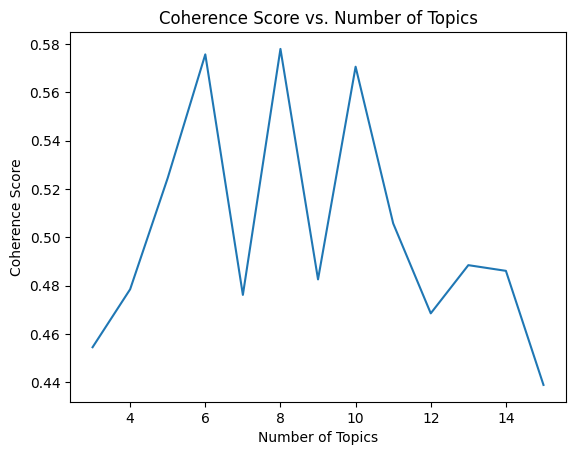

In [34]:
# Example hyperparameter tuning
import numpy as np
import matplotlib.pyplot as plt

# Vary the number of topics
num_topics_list = list(range(3, 16))
coherence_scores = []

#creates a model for each number of topics in the range and then produces a coherence model to see how well words in the clusters are connected to each other in making a topic
for num_topics in num_topics_list:
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha="auto"
    )
    coherence_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Plot the coherence scores, highest is the best
plt.plot(num_topics_list, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Topics')
plt.show()


In [35]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, # play around with. Coherence model helps guide to the best number for this, which are 6, 8, and 10
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")


## Visualize the different clusters of topics. 
- This is unsupervised so it is up to the user to determine the labeling of the actual clusters(topic for each cluster)

In [42]:
# visualizing the model and related details of it
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.014388  0.036939       1        1  31.411017
3      0.299205  0.040569       2        1  19.817995
1     -0.363047  0.126705       3        1  16.674856
5      0.158457 -0.309479       4        1  14.994780
0      0.067240  0.377928       5        1  10.825016
4     -0.176243 -0.272662       6        1   6.276337, topic_info=           Term         Freq        Total Category  logprob  loglift
748   headphone  1218.000000  1218.000000  Default  30.0000  30.0000
1006     remote   660.000000   660.000000  Default  29.0000  29.0000
3306        ear   659.000000   659.000000  Default  28.0000  28.0000
936       sound  1105.000000  1105.000000  Default  27.0000  27.0000
128        year   647.000000   647.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
228      device    54.194692   924.638058   Topic6  -4.8482  -0.0684
182        know    44.417260   292.676201   Topic6  -5.0471   0.8829
690       price    44.528356   369.701177   Topic6  -5.0446   0.6518
556     quality    43.907318   403.490780   Topic6  -5.0587   0.5503
85          get    39.895029   812.565770   Topic6  -5.1545  -0.2456

[366 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1035      6  0.914645    accord
1857      3  0.983804  accurate
1695      2  0.982207  activate
1184      4  0.978615        ad
1184      5  0.010996        ad
...     ...       ...       ...
1183      2  0.004459     write
1183      5  0.989991     write
128       1  0.355450      year
128       2  0.026272      year
128       5  0.616629      year

[514 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 6, 1, 5])

In [37]:
# main topics throughout all reviews after looking at most frequent words in each cluster
main_topics = [
    "Device and Display Experience",
    "Audio and Speaker Performance",
    "Headphones and Sound Quality",
    "Content Consumption and App/Software Experience",
    "General Product Review and Comparison",
    "TV Box and Streaming Experience"
]
